# Incrustaciones con BETO

La incrustación (*embedding*) es el proceso por el que obtenemos números a partir de palabras. En este caso, realizaremos ese proceso con [BETO](https://huggingface.co/dccuchile/bert-base-spanish-wwm-cased), la versión de BERT en español.

Lo que obtenemos finalmente es una columna llamada `mpBERT`, el mean-pooling de la incrustación.

Si bien algunas ya vienen pre-instaladas (como `pandas` o `numpy`, por ejemplo), en Google Colab debemos instalar las librerías cada vez que usemos un cuaderno.

In [ ]:
pip install matplotlib langdetect deep_translator

## 1. Importación de librerías y revisión del *dataframe*

In [ ]:
import pandas as pd
import numpy as np
import re #para identificar patrones en textos
from matplotlib import pyplot as plt
from langdetect import detect #para detectar idiomas, se tiene que instalar
from deep_translator import GoogleTranslator #para traducir texto, se tiene que instalar
import seaborn as sns
import os #para manipular archivos del sistema operativo
import torch
from transformers import BertTokenizer, BertModel
import time #para medir el tiempo de ejecución de algunas celdas

Con esto permitimos que importe archivos de nuestro Google Drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Reviso las columnas que tengo en mi dataframe.

In [ ]:
base=pd.read_excel('/content/drive/MyDrive/Documentos personales/9-Documentos Doctorado/Doctorado 2023/7-Clases/SRGVUA/rawdata/clases/habitaclia3971.xlsx')
print(base.columns.tolist())

['OBJECTID_1', 'codigo_inmueble1', 'Title', 'Type_build', 'Type_opera', 'Link', 'Location', 'Lat_X', 'Lon_Y', 'Climatic_Z', 'Nom_Mun', 'precio_eur', 'superficie', 'superficie_2', 'Unit_price', 'Ln_total_pr', 'Ln_unit_pr', 'numero_habitaciones', 'numero_bano', 'ratio_bano_hab', 'numero_aseo', 'ascensor', 'interac_planta', 'numero_de_piso', 'anyo_constr', 'anyo_constr_ponderad', 'antig_ponderad', 'Inverse_Age', 'Year_Before_1981', 'Year_1982_2006', 'Year_After_2007', 'superficie_terraza_m2', 'grand_terr_20m2', 'superficie_jardin_m2', 'superficie_salon', 'bool_despacho', 'bool_buhardilla', 'bool_trastero', 'bool_lavadero', 'bool_piscina_comunitaria', 'bool_jardin_comunitario', 'bool_amueblado', 'bool_ascensor', 'descripcion', 'bool_aire_acondicionado', 'bool_calefaccion', 'bool_chimenea', 'texto_destacado', 'calificacion_consumo_letra', 'calificacion_consumo_valor', 'calificacion_emision_letra', 'calificacion_emision_valor', 'Dum_EPC', 'EPC_A_emision', 'EPC_B_emision', 'EPC_C_emision', 'E

Con `Ctrl+F` puedo ver que hay dos que podrían tener la descripción de los anuncios. Las reviso.

In [ ]:
base[['Description','descripcion']].head()

,Description,descripcion
0,"Espectacular dúplex en finca de pocos vecinos,...",excelente
1,Espectacular piso en venta de obra seminueva d...,NaN
2,"[A2977]PISAZO, EL MEJOR DE LA ZONA.FENOMENAL P...",reformada
3,"Piso de 95 m2, distribuidos en: recibidor, 4 h...",muy bueno
4,"Piso de OBRA NUEVA en calle Riera de la Creu, ...",a estrenar


In [ ]:
len(base)

3971

## 2. Limpieza de `Description`

Paso a limpiar el texto. Defino una serie de funciones.

In [ ]:
def treat_euro(text):
    text = re.sub(r'(euro[^s])|(euros)|(€)', ' euros', text)
    return text

def treat_m2(text):
    text = re.sub(r'(m2)|(m²)', ' m²', text)
    return text

def filter_ibans(text):
    pattern = r'ES\d{2}[ ]\d{4}[ ]\d{4}[ ]\d{4}[ ]\d{4}[ ]\d{2}|ES\d{20}|ES[ ]\d{2}[ ]\d{3}[ ]\d{3}[ ]\d{3}[ ]\d{5}'
    text = re.sub(pattern, '', text)
    return text

def remove_space_between_numbers(text):
    text = re.sub(r'(\d)\s+(\d)', r'\1\2', text)
    return text

def filter_emails(text):
    pattern = r'(?:(?!.*?[.]{2})[a-zA-Z0-9](?:[a-zA-Z0-9.+!%-]{1,64}|)|\"[a-zA-Z0-9.+!% -]{1,64}\")@[a-zA-Z0-9][a-zA-Z0-9.-]+(.[a-z]{2,}|.[0-9]{1,})'
    text = re.sub(pattern, '', text)
    return text

def filter_ref(text):
    pattern = r'(\(*)(ref|REF)(\.|[ ])\d+(\)*)'
    text = re.sub(pattern, '', text)
    return text

def filter_websites(text):
    pattern = r'(http\:\/\/|https\:\/\/)?([a-z0-9][a-z0-9\-]*\.)+[a-z][a-z\-]*'
    text = re.sub(pattern, '', text)
    return text

def filter_phone_numbers(text):
    pattern = r'(?:(?:\+|00)33[\s.-]{0,3}(?:\(0\)[\s.-]{0,3})?|0)[1-9](?:(?:[\s.-]?\d{2}){4}|\d{2}(?:[\s.-]?\d{3}){2})|(\d{2}[ ]\d{2}[ ]\d{3}[ ]\d{3})'
    text = re.sub(pattern, '', text)
    return text

def remove_large_numbers(text):
    pattern = r'\b\d{4,}\b'
    text = re.sub(pattern, '', text)
    return text

def remove_text_in_brackets(text):
    pattern = r'\[[^\]]*\]|\{[^}]*\}'
    text = re.sub(pattern, '', text)
    return text

def remove_asterisks(text):
    text = re.sub(r'\*', '', text)
    return text

def remove_multiple_dashes(text):
    text = re.sub(r'(-{2,})', '', text)
    return text

def remove_multiple_spaces(text):
    text = re.sub(r'\s{2,}', ' ', text)
    return text

def remove_exclamation_marks(text):
    text = re.sub(r'[¡!]+', '', text)
    return text

Ahora agrupo todas esas funciones y las aplico a `base` para crear una nueva columna.

In [ ]:
start_time = time.time()

def clean_text(text):
    if isinstance(text, str):  # Verifica si text es una cadena de texto
        text = text.replace(u'\xa0', u' ')
        text = treat_m2(text)
        text = treat_euro(text)
        text = filter_phone_numbers(text)
        text = filter_emails(text)
        text = filter_ibans(text)
        text = filter_ref(text)
        text = filter_websites(text)
        text = remove_space_between_numbers(text)
        text = remove_large_numbers(text)
        text = remove_text_in_brackets(text)
        text = remove_asterisks(text)
        text = remove_multiple_dashes(text)
        text = remove_multiple_spaces(text)
        text = remove_exclamation_marks(text)
    return text

base['cl_descrip'] = base.Description.apply(clean_text)
base['cl_descrip'].head()

end_time = time.time()

In [ ]:
elapsed_time = end_time - start_time
print("Tiempo de ejecución: {:.2f} segundos".format(elapsed_time))

Tiempo de ejecución: 87.77 segundos


Tenemos un problema más: **¡Hay texto en catalán!** Y probablemente en algún otro idioma, dado que algunos anuncios los ponen en distintos idiomas a la vez.

## 3. Corte de la descripción y traducción al español

Debido al tamaño de nuestro dataframe, es probable que convenga cortar la cantidad de palabras por celda. Primero, veamos la extensión de cada anuncio.

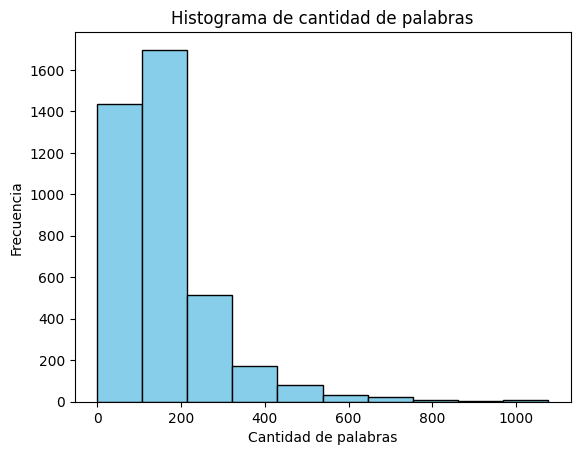

In [ ]:
# Reemplazar los valores NaN o no válidos con una cadena vacía ''
base['cl_descrip'] = base['cl_descrip'].fillna('')

# Dividir cada elemento de la columna 'cl_descrip' en palabras y contar la cantidad de palabras
base['cantidad_palabras'] = base['cl_descrip'].apply(lambda x: len(x.split()))

# Crear un histograma de la cantidad de palabras
plt.hist(base['cantidad_palabras'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Cantidad de palabras')
plt.ylabel('Frecuencia')
plt.title('Histograma de cantidad de palabras')
plt.show()

Podemos exportar el archivo para ver qué características tienen aquellos anuncios más largos.

In [ ]:
#base[['Description','cl_descrip','cantidad_palabras']].to_excel('/content/drive/MyDrive/Documentos personales/9-Documentos Doctorado/Doctorado 2023/7-Clases/SRGVUA/rawdata/clases/extension_borrar_luego.xlsx')

Lo que veo es que aquellos que están por arriba de 350 usualmente tienen texto repetido, sólo que en distintos idiomas. Por tanto, pongo ese límite para mi dataframe. Ustedes, si lo consideran necesario, pueden cambiarlo.

Empiezo creando una columna que me indique el idioma en el que está cada fila con la función `detect` de `langdetect`.

In [ ]:
# Función para detectar el idioma de un texto
def detect_language(text):
    try:
        return detect(text)
    except:
        return None

# Agrega una nueva columna 'Language' con el idioma detectado para cada descripción
base['Language'] = base['cl_descrip'].apply(detect_language)

In [ ]:
base['Language'].head()

0    es
1    es
2    en
3    es
4    es
Name: Language, dtype: object

Los resultados no parecen ser tan buenos, pues reconoce el catalán como alemán, y en algunos casos, el mismo español como alemán (esto lo noté al haber exportado el Excel y revisar caso por caso).
Sin embargo, esto no debería ser un gran problema: si a continuación le pido que todas aquellas filas con un idioma distinto al español (`!= 'es'`) sean traducidas a ese idioma, aquellas que ya estén en español no sufrirán mayores cambios.

In [ ]:
start_time = time.time()

#En caso haya alguna celda en blanco, la relleno con un espacio en blanco
base['cl_descrip'] = base['cl_descrip'].fillna('')

# Función para cortar el texto a un máximo de 350 palabras
def truncate_text(text):
    words = text.split()[:350]
    truncated_text = ' '.join(words)
    return truncated_text

# Aplico la función para truncar el texto en la columna 'cl_descrip'
base['cl_descrip'] = base['cl_descrip'].apply(truncate_text)

# Filtro las filas que tienen 'Language' algo distinto al español ('es')
no_esp_descriptions = base[base['Language'] != 'es']['cl_descrip']

# Traduzco las descripciones al español
translated_descriptions = []
for description in no_esp_descriptions:
    translated_description = GoogleTranslator(source='auto', target='es').translate(description)
    translated_descriptions.append(translated_description)

end_time = time.time()

# Reemplazo las descripciones traducidas en el DataFrame original
base.loc[base['Language'] != 'es', 'cl_descrip'] = translated_descriptions

base['cl_descrip'].head()

0    Espectacular dúplex en finca de pocos vecinos,...
1    Espectacular piso en venta de obra seminueva d...
2    PISAZO, EL MEJOR DE LA ZONA.FENOMENAL PISO SIN...
3    Piso de 95 m², distribuidos en: recibidor, 4 h...
4    Piso de OBRA NUEVA en calle Riera de la Creu, ...
Name: cl_descrip, dtype: object

In [ ]:
base['cl_descrip'].tail()

3966    
3967    
3968    
3969    
3970    
Name: cl_descrip, dtype: object

In [ ]:
elapsed_time = end_time - start_time
print("Tiempo de ejecución: {:.2f} segundos".format(elapsed_time))

Tiempo de ejecución: 56.63 segundos


## 4. Incrustación

La columna que había obtenido se llama `cl_descrip`. Así que sobre ella realizo la incrustación.

**Cuidado**: revisa el tiempo de ejecución de la siguiente celda de código.

In [ ]:
start_time = time.time()

# Cargar el modelo pre-entrenado y el tokenizador
model_name = "dccuchile/bert-base-spanish-wwm-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

def generate_bert_embeddings(description):
    if not isinstance(description, str) or not description.strip():
        return None  # Devolver None para descripciones vacías
    else:
        tokens = tokenizer(description, return_tensors='pt', padding=True, truncation=True)

        with torch.no_grad():
            outputs = model(**tokens)
            embeddings = outputs.last_hidden_state

        return embeddings.squeeze()

# Aplicar la función a la columna 'cl_descrip' y almacenar los resultados en una nueva columna 'mpBERT'
base['BERT'] = base['cl_descrip'].apply(lambda x: generate_bert_embeddings(x))

end_time = time.time()

# Ver el DataFrame resultante
base['BERT'].head()

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


KeyboardInterrupt: 

In [ ]:
elapsed_time = end_time - start_time
print("Tiempo de ejecución: {:.2f} segundos".format(elapsed_time))

Se han generado varios valores, pero por 768 dimensiones, que es el número de dimensiones con las que trabaja BETO. Ahora tenemos que hacer el mean-pooling.

In [ ]:
start_time = time.time()

def mean_pooling(embeddings):
    if embeddings is None:
        return None

    # Filtrar filas con valores vacíos
    valid_embeddings = [emb for emb in embeddings if emb is not None]

    if not valid_embeddings:
        return None  # Si no hay embeddings válidos, devolver None

    # Concatenar los embeddings válidos a lo largo de la dimensión 0
    concatenated = torch.cat(valid_embeddings, dim=0)

    # Calcular el promedio a lo largo de la dimensión 0
    pooled = torch.mean(concatenated, dim=0)

    # Extraer el valor escalar del tensor resultante
    pooled_scalar = pooled.item()
    return pooled_scalar

# Aplicar mean-pooling a cada fila en la columna 'BERT'
base['mpBERT'] = base['BERT'].apply(lambda x: mean_pooling(x))

end_time = time.time()

# Ver el DataFrame resultante
print(base['mpBERT'].head())

In [ ]:
elapsed_time = end_time - start_time
print("Tiempo de ejecución: {:.2f} segundos".format(elapsed_time))

Si quieren, pueden exportar a Excel lo que han obtenido para ir revisando un poco su estructura.

In [ ]:
#base[['cl_descrip','mpBERT']].to_excel('/content/drive/MyDrive/Documentos personales/9-Documentos Doctorado/Doctorado 2023/7-Clases/SRGVUA/rawdata/clases/bert_borrar_luego.xlsx')

He notado que he obtenido el mean-pooling de cada fila, con excepción de aquellas vacías. A ellas les asignaré automáticamente 0.

In [ ]:
base['mpBERT'] = base['mpBERT'].fillna(0)

Vuelvo a exportar.

In [ ]:
base.to_excel('/content/drive/MyDrive/Documentos personales/9-Documentos Doctorado/Doctorado 2023/7-Clases/SRGVUA/data/clases/habitaclia3971_1y2.xlsx')
